In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
data = pd.read_csv("AAPL_stock_data.csv", parse_dates=['Date'])
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,19.845715,19.893929,19.715000,19.754642,17.253258,234684800
1,2014-01-03,19.745001,19.775000,19.301071,19.320715,16.874271,392467600
2,2014-01-06,19.194643,19.528570,19.057142,19.426071,16.966295,412610800
3,2014-01-07,19.440001,19.498571,19.211430,19.287144,16.844957,317209200
4,2014-01-08,19.243214,19.484285,19.238930,19.409286,16.951635,258529600
5,2014-01-09,19.528570,19.530714,19.119642,19.161428,16.735153,279148800
6,2014-01-10,19.279642,19.314285,18.968214,19.033571,16.623491,304976000
7,2014-01-13,18.925358,19.375000,18.924286,19.133215,16.710518,378492800
8,2014-01-14,19.222143,19.526072,19.202143,19.513929,17.043024,332561600
9,2014-01-15,19.768572,20.007143,19.702143,19.905714,17.385193,391638800


In [3]:
## add two new columns 
# Calculate daily returns
data['Daily Return'] = data['Close'].pct_change()

# Calculate volatility (30-day rolling standard deviation of daily returns)
data['Volatility'] = data['Daily Return'].rolling(window=30).std()

In [4]:
data[['Close', 'Daily Return', 'Volatility']].head()

,Close,Daily Return,Volatility
0,19.754642,NaN,NaN
1,19.320715,-0.021966,NaN
2,19.426071,0.005453,NaN
3,19.287144,-0.007152,NaN
4,19.409286,0.006333,NaN


In [5]:
## check if any value in dataframe is null
data.isnull().values.any()

True

In [6]:
## add columns for moving average
data['MA50'] = data['Close'].rolling(window=50).mean()  # 50-day moving average
data['MA200'] = data['Close'].rolling(window=200).mean()  # 200-day moving average

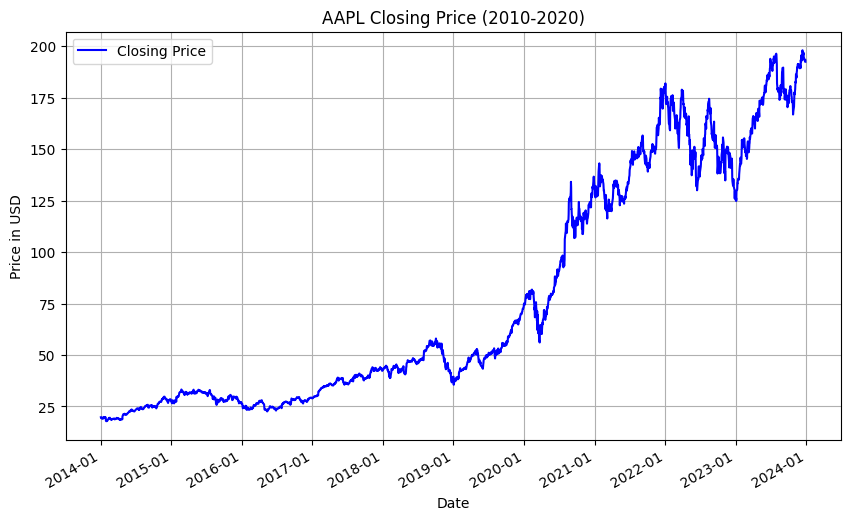

In [7]:
# Plot the closing price
plt.figure(figsize=(10,6))
# plt.plot(data['Open'], label='Opening Price', color='orange')
plt.plot(data['Date'], data['Close'], label='Closing Price', color='blue')

# Format the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Month
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto locates the date ticks

plt.title('AAPL Closing Price (2010-2020)')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
# Rotate the date labels for better visibility
plt.gcf().autofmt_xdate()

plt.grid(True)
plt.show()

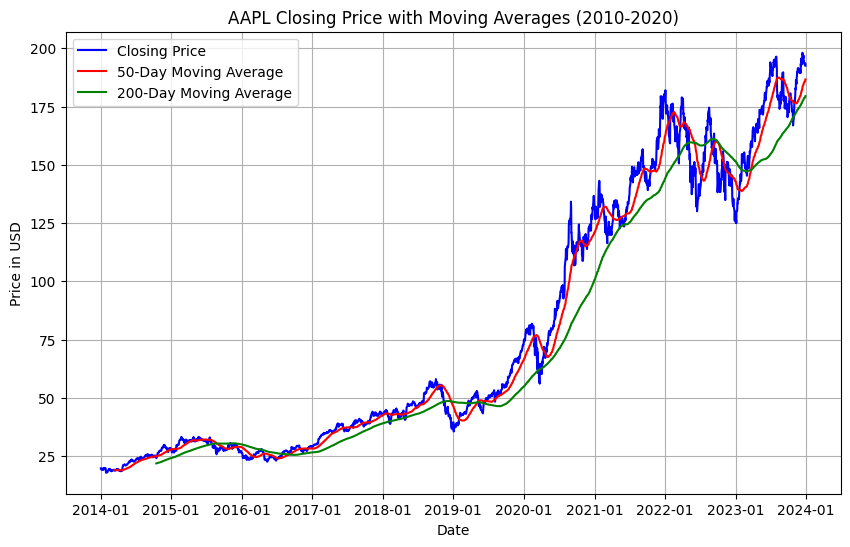

In [8]:

# Plotting moving averages
plt.figure(figsize=(10,6))

plt.plot(data['Date'], data['Close'], label='Closing Price', color='blue')
plt.plot(data['Date'], data['MA50'], label='50-Day Moving Average', color='red')
plt.plot(data['Date'], data['MA200'], label='200-Day Moving Average', color='green')

# Format the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Month
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto locates the date ticks

plt.title('AAPL Closing Price with Moving Averages (2010-2020)')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(True)
plt.show()

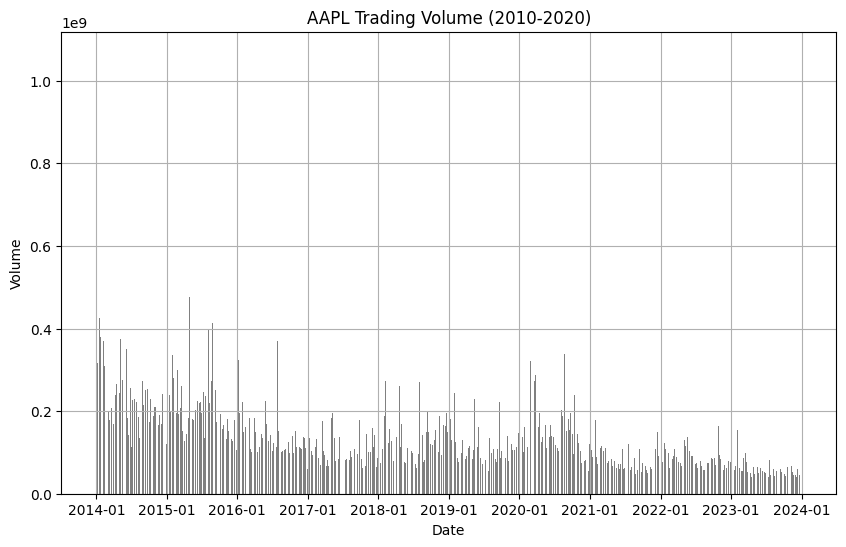

In [9]:
# Plot the volume
plt.figure(figsize=(10,6))
plt.bar(data['Date'], data['Volume'], color='gray')

# Format the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as Year-Month
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Auto locates the date ticks

plt.title('AAPL Trading Volume (2010-2020)')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

In [10]:
data.isnull().values.any()

True

In [11]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Initializing the MinMaxScaler to scale the data to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fitting the scaler to the 'Close' price data and transforming it
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Creating sequences for training the model
X_train = []  # List to hold the input features
y_train = []  # List to hold the target values

# Looping through the scaled data starting from index 60
for i in range(60, len(scaled_data)):
    # Appending the previous 60 days' closing prices as the input feature
    X_train.append(scaled_data[i-60:i, 0])
    # Appending the next day's closing price as the target value
    y_train.append(scaled_data[i, 0])

# Converting the lists into NumPy arrays for better performance with machine learning models
X_train, y_train = np.array(X_train), np.array(y_train)

# Convert data types to float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

# Reshape X_train to be a 3D array for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # Shape: (samples, timesteps, features)
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))


In [12]:
print("X_train shape:", X_train.shape)  # Should print (samples, 60, 1)
print("y_train shape:", y_train.shape)  # Should print (samples,)

X_train shape: (2456, 60, 1)
y_train shape: (2456,)


In [13]:
print(X_train.dtype)  # Should be float32
print(y_train.dtype)  # Should be float32

float32
float32


In [14]:
print(type(X_train))  # Should be <class 'numpy.ndarray'>
print(type(y_train))  # Should be <class 'numpy.ndarray'>

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [15]:
from keras import backend as K
K.clear_session()

In [16]:
# Importing necessary classes from Keras
from keras.models import Sequential  # Sequential model for stacking layers linearly
from keras.layers import LSTM, Dense, Dropout, Input  # Importing LSTM, Dense, and Dropout layers


# Initializing the Sequential model
model = Sequential()

model.add(Input(shape=(X_train.shape[1], 1)))

# Adding the first LSTM layer
# 'units' specifies the number of neurons in the layer
# 'return_sequences=True' allows us to stack another LSTM layer on top of this one
# 'input_shape' defines the shape of the input data (timesteps, features)
model.add(LSTM(units=50, return_sequences=True))
# Adding a Dropout layer to prevent overfitting by randomly setting a fraction of input units to 0
model.add(Dropout(0.2))

# Adding the second LSTM layer
# 'return_sequences=False' since this is the last LSTM layer
model.add(LSTM(units=50, return_sequences=False))
# Adding another Dropout layer to further reduce overfitting
model.add(Dropout(0.2))

# Adding a Dense layer with 25 units as an intermediate layer
# This layer can learn the combination of the previous layer's output
model.add(Dense(units=25))
# Adding the final Dense layer with 1 unit to output the predicted stock price
model.add(Dense(units=1))

# Compiling the model
# 'optimizer' is set to 'adam', which is an efficient gradient descent algorithm
# 'loss' is set to 'mean_squared_error', a common loss function for regression problems
model.compile(optimizer='adam', loss='mean_squared_error')

# Fitting the model to the training data
# 'batch_size=1' means the model will be updated after each sample
# 'epochs=1' indicates the number of complete passes through the training data
model.fit(X_train, y_train, batch_size=1, epochs=1)


2456/2456 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0058


In [17]:
# Making predictions
predictions = model.predict(X_train)

# Inverse transform the predictions to get the actual prices
predictions = scaler.inverse_transform(predictions)

77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [18]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, predictions))
print("RMSE:", rmse)


RMSE: 101.466515


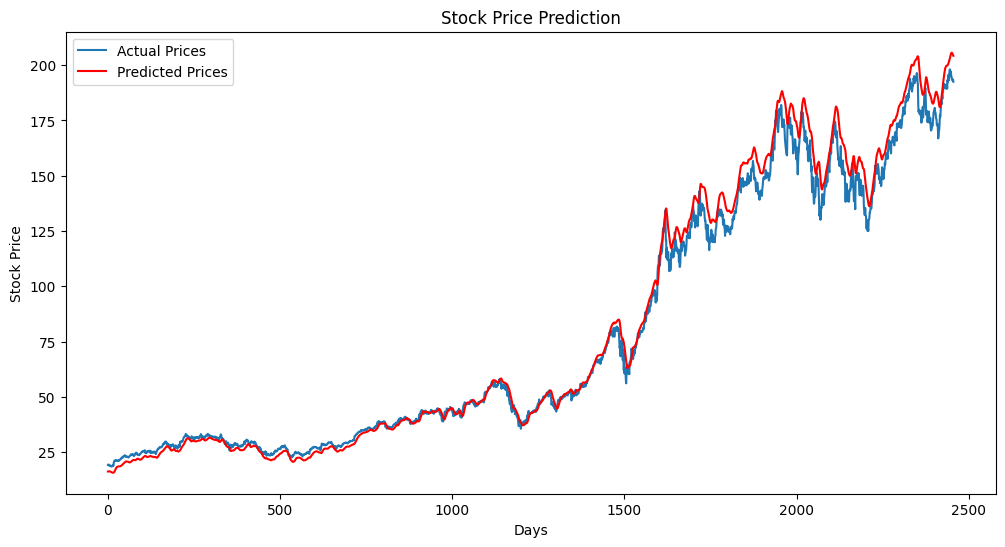

In [19]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(data['Close'].values[60:], label='Actual Prices')
plt.plot(predictions, label='Predicted Prices', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [20]:
model.save('stock_price_model.h5')

In [21]:
model.save('stock_price_model.keras')